In [11]:
from run_fit import *
import corner

inst = 1

for ifield in [0,4,5,6,7,8]:
    if ifield==0:
        truths_arr = []
    for im in range(4):
        R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
        if ifield==0:
            savename = 'mcmc_2par_joint' + \
            '_m' + str(magbindict['m_min'][im]) + '_' + str(magbindict['m_max'][im]) + '.npy'
        else:
            savename = 'mcmc_2par_' + fieldnamedict[ifield] + \
            '_m' + str(magbindict['m_min'][im]) + '_' + str(magbindict['m_max'][im]) + '.npy'
        
        savedir = mypaths['alldat'] + 'TM' + str(inst) + '/'
        samples = np.load(savedir + savename)
        steps, nwalkers, nparams = samples.shape

        flatsamps = samples.copy()
        flatsamps[:,:,0] = flatsamps[:,:,0] * R200
        flatsamps = flatsamps[100:,:,:].reshape((-1,2))

        bins0 = np.linspace(np.min(flatsamps[:,0]), np.max(flatsamps[:,0]), 20)
        bins1 = np.linspace(np.min(flatsamps[:,1]), np.max(flatsamps[:,1]), 20)
        
        if ifield==0:
            truths_arr.append(np.median(flatsamps, axis=0))

        levels= 1.0 - np.exp(-0.5 * np.arange(1, 2.1, 1) ** 2)
        figure = corner.corner(flatsamps, levels = levels,fill_contours=True,plot_datapoints=False,
                               bins=[bins0, bins1],label_kwargs={'fontsize':'xx-large'},
                               range=[(0,5),(0,200)],
                               title_kwargs={'fontsize':'x-large'},
                               show_titles=True,labels=["$R_{e_2}$", r"$b_gb_I\frac{dI}{dz}$"],
                               truths=truths_arr[im])

        if ifield==0:
            plt.savefig('plots/TM%d/mcmc_joint_m%d_%d.png'\
                        %(inst,magbindict['m_min'][im], magbindict['m_max'][im]), dpi=150)
        else:
            plt.savefig('plots/TM%d/mcmc_%s_m%d_%d.png'\
                        %(inst,fieldnamedict[ifield], 
                          magbindict['m_min'][im], magbindict['m_max'][im]), dpi=150)

        plt.close()

# combine four mag plots into one plot
from run_fit import *
from PIL import Image
import os

for ifield in [0,4,5,6,7,8]:
    result = Image.new("RGB", (3200,800))    
    for im in range(4):
        fieldname = 'joint' if ifield==0 else fieldnamedict[ifield]
        fname = 'plots/TM%d/mcmc_%s_m%d_%d.png'\
                        %(inst, fieldname, im+16, im+17)
        path = os.path.expanduser(fname)
        img = Image.open(path)
        img.thumbnail((800, 800), Image.ANTIALIAS)
        x = im * 800
        y = 0
        w, h = img.size
        result.paste(img, (x, y, x + w, y + h))
        os.remove(fname)
    
    result.save(os.path.expanduser('plots/TM%d/mcmc_%s.png'%(inst,fieldname)))

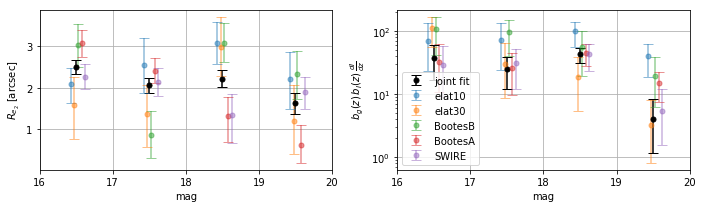

In [14]:
#
from run_fit import *

inst = 1

fig, ax = plt.subplots(1, 2, figsize = (10,3))
for ifield in [None,4,5,6,7,8]:
    xoff = 0 if ifield is None else (ifield-5.5)*0.05
    m_arr = np.zeros(4)
    Re2_arr = np.zeros(4)
    Aclus_arr = np.zeros(4)
    Re2_low_arr = np.zeros(4)
    Aclus_low_arr = np.zeros(4)
    Re2_high_arr = np.zeros(4)
    Aclus_high_arr = np.zeros(4)
    for im in range(4):
        fitparamdat = get_mcmc_fit_params(inst,im, ifield=ifield)
        Re2_arr[im] = fitparamdat['Re2']
        Aclus_arr[im] = fitparamdat['Aclus']
        Re2_low_arr[im] = fitparamdat['Re2_low']
        Aclus_low_arr[im] = fitparamdat['Aclus_low']
        Re2_high_arr[im] = fitparamdat['Re2_high']
        Aclus_high_arr[im] = fitparamdat['Aclus_high']

        m_arr[im] = im + 16.5

    if ifield is None:
        ax[0].errorbar(m_arr+xoff, Re2_arr, [Re2_arr - Re2_low_arr, Re2_high_arr - Re2_arr],
                      fmt='.', capsize=5, markersize=10, c='k')
        ax[1].errorbar(m_arr+xoff, Aclus_arr, [Aclus_arr - Aclus_low_arr, Aclus_high_arr - Aclus_arr],
                      fmt='.', capsize=5, markersize=10, c='k', label = 'joint fit')
    else:
        ax[0].errorbar(m_arr+xoff, Re2_arr, [Re2_arr - Re2_low_arr, Re2_high_arr - Re2_arr],
                      fmt='.', capsize=5, markersize=10, alpha = 0.5)
        ax[1].errorbar(m_arr+xoff, Aclus_arr, [Aclus_arr - Aclus_low_arr, Aclus_high_arr - Aclus_arr],
                      fmt='.', capsize=5, markersize=10, label = fieldnamedict[ifield], alpha = 0.5)

ax[1].legend()
ax[0].set_xlabel('mag')
ax[0].set_ylabel(r"$R_{e_2}$ [arcsec]")
ax[1].set_xlabel('mag')
ax[1].set_ylabel(r"$b_g(z)\,b_I(z)\,\frac{dI}{dz}$")
ax[1].set_yscale('log')
ax[0].set_xticks([16,17,18,19,20])
ax[1].set_xticks([16,17,18,19,20])
ax[0].grid()
ax[1].grid()

plt.tight_layout()
plt.savefig('plots/TM%d/params_best.png'%inst, dpi = 150)

In [ ]:
#
from run_fit import *

inst = 1

profclus_arr_joint = []
profex_arr_joint = []
chi2_joint = []
for im in range(4):
    param_fit = fit_stacking_mcmc(inst, 4, im)
    fitparamdat = get_mcmc_fit_params(inst,im)
    xe2 = fitparamdat['xe2']
    Aclus = fitparamdat['Aclus']
    profex_arr, profclus_arr = param_fit.get_profexcess_model(xe2=xe2, Aclus=Aclus)
    profclus_arr_joint.append(profclus_arr)
    profex_arr_joint.append(profex_arr)
    chi2 = joint_fit_mcmc(inst,im).get_chi2(xe2=xe2, Aclus=Aclus)
    chi2_joint.append(chi2)

for ifield in [4]:#[4,5,6,7,8]:
    fig, ax = plt.subplots(1, 4, figsize = (16,3))
    for im in range(4):
        param_fit = fit_stacking_mcmc(inst, ifield, im)
        fitparamdat = get_mcmc_fit_params(inst,im, ifield=ifield)
        Re2 = fitparamdat['Re2']
        Aclus = fitparamdat['Aclus']
        r_arr = param_fit.r_arr
        profd_arr = param_fit.profd_arr
        profd_err = param_fit.profd_err_diag
        profex_arr, profclus_arr = param_fit.get_profexcess_model(Re2=Re2, Aclus=Aclus)
        chi2 = param_fit.get_chi2(Re2=Re2, Aclus=Aclus)
        rbinedges = profile_rbinedges(r_arr)

        ax[im].loglog(r_arr, profclus_arr,'g:')
        ax[im].loglog(r_arr, profex_arr,'g--')
        ax[im].loglog(r_arr, profex_arr + profclus_arr,'g-', lw=2,
                     label = fieldnamedict[ifield] + ' $\chi^2/dof=$%.2f/13'%chi2)
        ax[im].loglog(r_arr, profclus_arr_joint[im],'r:')
        ax[im].loglog(r_arr, profex_arr_joint[im],'r--')
        ax[im].loglog(r_arr, profex_arr_joint[im] + profclus_arr_joint[im],'r-', lw=2,
                     label = 'joint'+' $\chi^2/dof=$%.2f/73'%chi2_joint[im])

        x_err_low = r_arr - rbinedges[:-1]
        x_err_high = rbinedges[1:] - r_arr
        spp = np.where(profd_arr >= 0)[0]
        spn = np.where(profd_arr < 0)[0]
        ax[im].errorbar(r_arr[spp], profd_arr[spp], profd_err[spp], 
                    [x_err_low[spp], x_err_high[spp]],
                 fmt='.', color='k',capsize=5, markersize=10)
        ax[im].errorbar(r_arr[spn], -profd_arr[spn], profd_err[spn], 
                        [x_err_low[spn], x_err_high[spn]],
                     fmt='.', mfc='white', color='k',capsize=5, markersize=10)
        ax[im].set_title('%d < m < %d'%(param_fit.m_min, param_fit.m_max))
        ax[im].set_ylim([1e-3,3e2])
        ax[im].set_xlim([1e0,1e3])
        ax[im].grid()
        ax[im].legend()
        ax[im].set_xlabel('r [arcsec]')
    ax[0].set_ylabel('Excess profile [$mW/m^2/sr$]')
    fig.suptitle(fieldnamedict[ifield], fontsize=16)

    plt.tight_layout()
    plt.savefig('plots/TM%d/profile_best_%s.png'%(inst,param_fit.field), dpi = 150)